# Description

This notebook runs rapidtide in all runs.

1. Create ouput folder

2. Runs rapidtide following the BASICnobpf pipeline. 

3. Removes a lot of unnecessary outputs from rapidtide.

4. Create Thresholded versions of the lag and corr maps

# Primary Outputs

* ```${DATA_DIR}/${SBJ}/${RUN}/${RUN}_BASICnobpf.rapidtide/${RUN}_BASICnobpf_corrout.nii.gz```:
* ```${DATA_DIR}/${SBJ}/${RUN}/${RUN}_BASICnobpf.rapidtide/${RUN}_BASICnobpf_lagtimes.nii.gz```:
* ```${DATA_DIR}/${SBJ}/${RUN}/${RUN}_BASICnobpf.rapidtide/${RUN}_BASICnobpf_p_lt_0p005_mask.nii.gz```:
* ```${DATA_DIR}/${SBJ}/${RUN}/${RUN}_BASICnobpf.rapidtide/${RUN}_BASICnobpf_corrout.masked_0p005.nii.gz```:
* ```${DATA_DIR}/${SBJ}/${RUN}/${RUN}_BASICnobpf.rapidtide/${RUN}_BASICnobpf_lagtimes.masked_0p005.nii.gz```:



In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import subprocess

from nilearn.plotting import plot_stat_map
from nilearn.image    import load_img, index_img

from utils.variables import Resources_Dir, DATA_DIR
from utils.basics    import get_available_runs
ALL_DIR  = '/data/SFIMJGC_HCP7T/HCP7T/ALL/'

import hvplot.pandas
import panel as pn
import matplotlib.pyplot as plt

/data/SFIMJGC_HCP7T/Apps/envs/hcp7t_fv_sleep_env/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


***
# 1. Load list of runs

In [2]:
Manuscript_Runs = get_available_runs('final')
print('++ INFO: Number of Runs = %d' % len(Manuscript_Runs))

++ INFO: Number of Runs = 404


***

# 2. Create Swarm Infrastructure: swarm file, log directory, etc.

In [3]:
if not osp.exists('./N07_RapidTide.logs'):
    print('++ INFO: Creating logging dir')
    os.mkdir('./N07_RapidTide.logs')

In [4]:
# Create Swarm file for extracting representative power
# ==========================================================
os.system('echo "#swarm -f ./N07_RapidTide.SWARM.sh -g 128 -t 32 --partition quick,norm --logdir ./N07_RapidTide.logs" > ./N07_RapidTide.SWARM.sh')
for sbj_run in Manuscript_Runs:
    sbj,run  = sbj_run.split('_',1)
    os.system('echo "export SBJ={sbj} RUN={run}; sh ./N07_RapidTide.sh" >> ./N07_RapidTide.SWARM.sh'.format(sbj=sbj, run=run, ddir=DATA_DIR))

Now we need to submit the Swarm file to the biowulf system:

```bash
cd /data/SFIMJGC_HCP7T/PRJ_Sleep/Notebooks/mPP_analysis/
rm ./N07_RapidTide.logs/*
swarm -f ./N07_RapidTide.SWARM.sh -g 128 -t 32 --partition quick,norm --logdir ./N07_RapidTide.logs
watch -n 30 squeue -u javiergc
```

***

# 3. Check all outputs exists

In [5]:
%%time
for item in Manuscript_Runs:
    sbj,run = item.split('_',1)
    for suffix in ['BASICnobpf_corrout.nii.gz', 'BASICnobpf_lagtimes.nii.gz', 'BASICnobpf_p_lt_0p005_mask.nii.gz', 
                   'BASICnobpf_corrout.masked_0p005.nii.gz', 'BASICnobpf_lagtimes.masked_0p005.nii.gz']:
        path = osp.join(DATA_DIR,sbj,run,'{run}_BASICnobpf.rapidtide'.format(run=run),'{run}_{suffix}'.format(run=run, suffix=suffix))
        if not osp.exists(path):
            print ('++ WARNING: Primary output missing [%s]' % path)

CPU times: user 23.8 ms, sys: 59.4 ms, total: 83.2 ms
Wall time: 1.65 s


***
# 4. Create Group-level Lag Maps (p<0.05)

The steps involved in this calculation are:

1. Concatenate lagmaps for all subjects into a single file (we do this to be able to use 3dTstat in the next step)
2. Compute the nzmean and nzmedian across all subjects' lagmaps
3. Remove voxels that did not reach significance (p<0.05) for at least half the sample.

> **Main Output:**  /data/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050.lagtimes_summary.nii.gz

In [6]:
Drowsy_Runs = get_available_runs(when='final',type='drowsy')
print('++ INFO: Number of Runs = %d' % len(Drowsy_Runs))

++ INFO: Number of Runs = 194


### 4.1 Create lists with the paths to all necessary files

Here we gather files names into three dictionary objects:

* masked_corrout: cross-correlation traces only for voxels that passed the threshold

* masked_lagtimes: lagtime maps only for voxels that passed the threshold

* masks: mask with voxels that passed the threshold

In [7]:
%%time
# Gather all mask and masked lagtime files for drwosy subjects for the different p-values
# =======================================================================================
p_threshold = '0p050'
masks, masked_lagtimes,masked_corrout = list(),list(),list()
for item in Drowsy_Runs:
    sbj,run = item.split('_',1)
    mask_path           = osp.join(DATA_DIR,sbj,run,run+'_BASICnobpf.rapidtide',run+'_BASICnobpf_p_lt_{pval}_mask.nii.gz'.format(pval=p_threshold))
    masked_lagtime_path = osp.join(DATA_DIR,sbj,run,run+'_BASICnobpf.rapidtide',run+'_BASICnobpf_lagtimes.masked_{pval}.nii.gz'.format(pval=p_threshold))
    masked_corrout_path = osp.join(DATA_DIR,sbj,run,run+'_BASICnobpf.rapidtide',run+'_BASICnobpf_corrout.masked_{pval}.nii.gz'.format(pval=p_threshold))
    if osp.exists(mask_path):
        masks.append(mask_path)
    else:
        print(' ++ WARNING: Missing mask [%s]' % mask_path)
    if osp.exists(masked_lagtime_path):
        masked_lagtimes.append(masked_lagtime_path)
    else:
        print('++ WARNING: Missing lagtime map [%s]' % masked_lagtime_path)
    if osp.exists(masked_corrout_path):
        masked_corrout.append(masked_corrout_path)
    else:
        print('++ WARNING: Missing corrout map [%s]' % masked_corrout_path)
    
print('++ INFO: Number of files gathered: (corrout=%d, lagtimes=%d, mask=%d)' % (len(masked_corrout),len(masked_lagtimes),len(masks)))

++ INFO: Number of files gathered: (corrout=194, lagtimes=194, mask=194)
CPU times: user 5.68 ms, sys: 15.2 ms, total: 20.9 ms
Wall time: 295 ms


### 4.2. Create group masks with count of how many runs passed the threshold in each voxel

For each subject, rapidtide generated one file with a mask informing about which voxels have a significant cross-correlation result (e.g., SBJ_DIR/RUN_DIR/rfMRI_REST2_AP_BASICnobpf.rapidtide/rfMRI_REST2_AP_BASICnobpf_p_lt_0p050_mask.nii.gz). 

We average those to create a single significance mask (**FINAL_0p050_mask_path**).

In [8]:
%%time
FINAL_0p050_mask_path = osp.join(DATA_DIR,'ALL','ALL.rapidtide_BASICnobpf_p_lt_{pval}_mask.nii.gz'.format(pval='0p050'))
command               = 'module load afni; 3dMean -overwrite -prefix {prefix} {input_files}'.format(prefix=FINAL_0p050_mask_path, input_files=' '.join(masks))
output                = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())
print('++ INFO: Final significance mask for rapidtide (p<0.05) --> %s' % FINAL_0p050_mask_path)

[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2021-10-29

++ 3dMean: AFNI version=AFNI_21.3.04 (Oct 20 2021) [64-bit]
++ INFO: Final significance mask for rapidtide (p<0.05) --> /data/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050_mask.nii.gz
CPU times: user 3.18 ms, sys: 13.6 ms, total: 16.8 ms
Wall time: 9.44 s


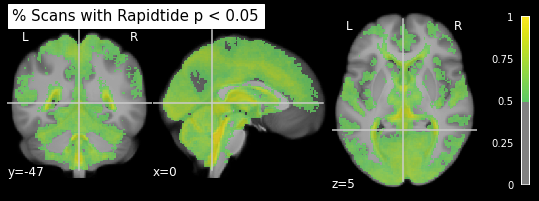

In [9]:
%matplotlib inline
t1_bg    = load_img(osp.join(ALL_DIR,'ALL_T1w_restore_brain.nii.gz'))
mask_img = load_img(FINAL_0p050_mask_path)
plot_stat_map(mask_img,t1_bg,alpha=0.8,threshold=0.5, cmap='viridis', title='% Scans with Rapidtide p < 0.05');

### 4.3 Create Voxel-wise Group-level Lag Map

The steps involved in this calculation are:

1. Concatenate lagmaps for all subjects into a single file (we do this to be able to use 3dTstat in the next step)
2. Compute the nzmean and nzmedian across all subjects' lagmaps
3. Remove voxels that did not reach significance (p<0.05) for at least half the sample.

In [10]:
%%time
FINAL_0p050_lagmap_path = osp.join(DATA_DIR,'ALL','ALL.rapidtide_BASICnobpf_p_lt_{pval}.lagtimes_summary.nii.gz'.format(pval=p_threshold))
aux_output1_path        = osp.join(DATA_DIR,'ALL','ALL.rapidtide_BASICnobpf_p_lt_{pval}_all.nii.gz'.format(pval=p_threshold))
aux_output2_path        = osp.join(DATA_DIR,'ALL','ALL.rapidtide_BASICnobpf_p_lt_{pval}.lagtimes_summary_nomask.nii.gz'.format(pval=p_threshold))
command                 = 'module load afni; \
                           echo "++ INFO: Combine all lag maps from all subjects into a single file"; \
                           echo "   ==============================================================="; \
                           3dTcat  -overwrite -prefix {output_1} {input_files}; \
                           echo "++ INFO: Compute basic statistics across subjects" ; \
                           echo "   =============================================="; \
                           3dTstat -overwrite -nzmean -nzmedian -mean -median -prefix {output_2} {output_1}; \
                           echo "++ INFO: Restrict group maps to voxels that were significant in at least half the sample"; \
                           echo "   ====================================================================================="; \
                           3dcalc  -overwrite -a {output_2} -b {mask} -expr "a*ispositive(b-0.5)" -prefix {output_3}; rm {output_1}; \
                           echo "++ INFO: Trick to avoid issue regarding 5th dimension in nilearn"; \
                           echo "   ============================================================="; \
                           3dTcat -overwrite -prefix {output_3} {output_3};'.format(output_1=aux_output1_path,
                                                                                                                                output_2   = aux_output2_path,
                                                                                                                                output_3   = FINAL_0p050_lagmap_path,
                                                                                                                                mask       = FINAL_0p050_mask_path,
                                                                                                                                input_files= ' '.join(masked_lagtimes))
output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())
print('++ INFO: Final significance mask for rapidtide (p<0.05) --> %s' % FINAL_0p050_lagmap_path)

[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2021-10-29

++ INFO: Combine all lag maps from all subjects into a single file
++ 3dTcat: AFNI version=AFNI_21.3.04 (Oct 20 2021) [64-bit]
*+ WARNING: Set TR of output dataset to 1.0 s
++ elapsed time = 33.5 s
++ INFO: Compute basic statistics across subjects
++ 3dTstat: AFNI version=AFNI_21.3.04 (Oct 20 2021) [64-bit]
++ Authored by: KR Hammett & RW Cox
++ Warning: 1281005 bad floats computed in MAKER_4D_to_typed_fbuc
++ Output dataset /data/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050.lagtimes_summary_nomask.nii.gz
++ INFO: Restrict group maps to voxels that were significant in at least half the sample
++ 3dcalc: AFNI version=AFNI_21.3.04 (Oct 20 2021) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset /data/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050.lagtimes_summary.nii.gz
++ INFO: Trick to avoid issue regarding 5th dimension in nilearn
++ 3dTcat: AFNI version=AFNI_21

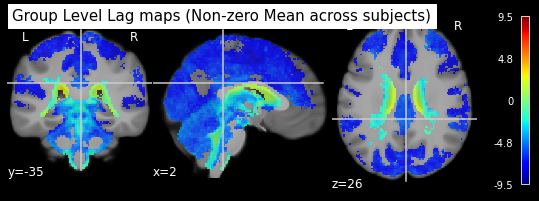

In [11]:
lagmap_img = load_img(index_img(FINAL_0p050_lagmap_path,0))
plot_stat_map(lagmap_img,t1_bg,alpha=0.8, cmap='jet', title='Group Level Lag maps (Non-zero Mean across subjects)');

In [12]:
FINAL_0p050_mask_path   = osp.join(DATA_DIR,'ALL','ALL.rapidtide_BASICnobpf_p_lt_{pval}_mask.nii.gz'.format(pval='0p050'))
FINAL_0p050_lagmap_path = osp.join(DATA_DIR,'ALL','ALL.rapidtide_BASICnobpf_p_lt_{pval}.lagtimes_summary.nii.gz'.format(pval='0p050'))
print('++ INFO: Final significance map for rapidtide (p<0.05)          --> %s' % FINAL_0p050_mask_path)
print('++ INFO: Final average lagtime map across all subjects (p<0.05) --> %s' % FINAL_0p050_lagmap_path)

++ INFO: Final significance map for rapidtide (p<0.05)          --> /data/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050_mask.nii.gz
++ INFO: Final average lagtime map across all subjects (p<0.05) --> /data/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050.lagtimes_summary.nii.gz


***

# 5. Generation of Group-level Cross-Correlation traces

For each lag, we compute the average across all subjects of the cross-correlation traces for that particular lag. For each voxel, we only use data from subjects for which that particular voxel was significant according to rapidtide.

In [24]:
%%time
nvols=31
# First we need to do this on a sub-brick by sub-brick fashion, then we will put them together with 
# 3dTcat or 3dTbucket
# =================================================================================================
for pval in ['0p050']:
    print('++++++++++++ ----------------------- %s ---------------------- ++++++++++++' % (pval))
    for v in np.arange(nvols):
        print(v,end='..')
        input_files  = ' '.join([file+'[{v}]'.format(v=v) for file in masked_corrout])
        output1_path = osp.join(DATA_DIR,'ALL','rm.ALL.rapidtide_BASICnobpf_p_lt_{pval}_all.v{v}.nii.gz'.format(pval=pval,v=str(v).zfill(2)))
        output2_path = osp.join(DATA_DIR,'ALL','rm.ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.v{v}.nii.gz'.format(pval=pval,v=str(v).zfill(2)))
        mask_path    = osp.join(DATA_DIR,'ALL','ALL.rapidtide_BASICnobpf_p_lt_{pval}_mask.nii.gz'.format(pval=pval))
        command = 'module load afni;                                                            \
               3dTcat -overwrite -prefix {output_1} {input_files};                              \
               3dcalc -overwrite -a {output_1} -expr "atanh(a)" -prefix  {output_1};             \
               3dTstat -overwrite -nzmean -prefix {output_2} {output_1};                         \
               3dcalc -overwrite -a {output_2} -expr "tanh(a)" -prefix {output_2};               \
               3dcalc -overwrite \
                      -a {output_2} \
                      -b {mask} \
                      -expr "a*ispositive(b-0.5)" \
                      -prefix {output_2}; \
              rm {output_1}'.format(output_1=output1_path,
                                    output_2=output2_path,
                                    mask=mask_path,
                                    input_files=input_files)
        output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        print(output.strip().decode())

++++++++++++ ----------------------- 0p050 ---------------------- ++++++++++++
0..[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2021-10-25

++ 3dTcat: AFNI version=AFNI_21.3.04 (Oct 20 2021) [64-bit]
++ elapsed time = 205.9 s
++ 3dcalc: AFNI version=AFNI_21.3.04 (Oct 20 2021) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset /data/SFIMJGC_HCP7T/HCP7T/ALL/rm.ALL.rapidtide_BASICnobpf_p_lt_0p050_all.v00.nii.gz
++ 3dTstat: AFNI version=AFNI_21.3.04 (Oct 20 2021) [64-bit]
++ Authored by: KR Hammett & RW Cox
++ Warning: 1281005 bad floats computed in MAKER_4D_to_typed_fbuc
++ Output dataset /data/SFIMJGC_HCP7T/HCP7T/ALL/rm.ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.v00.nii.gz
++ 3dcalc: AFNI version=AFNI_21.3.04 (Oct 20 2021) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset /data/SFIMJGC_HCP7T/HCP7T/ALL/rm.ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.v00.nii.gz
++ 3dcalc: AFNI version=AFNI_21.3.04 (Oct 20 2021) [64-bit]
++

We now put together the results from the previous cell into a single file with all the datapoints. This code sets the time origin to -15s (which is what the original corrout datasets had). As TR is 1s, this does not need fixing as of now --> it might if you take out the -O 1 from rapidtide and or the data has a different TR

> The following code assumes a directory named "temps_results" exists in /data/SFIMJGC_HCP7T/HCP7T/ALL

In [14]:
%%time
if not osp.exists('/data/SFIMJGC_HCP7T/HCP7T/ALL/temp_lag_results'):
    os.mkdir('/data/SFIMJGC_HCP7T/HCP7T/ALL/temp_lag_results')
    print("++ INFO: Temporary folder created: /data/SFIMJGC_HCP7T/HCP7T/ALL/temp_lag_results")

pval = '0p050'
command = 'module load afni; \
               cd /data/SFIMJGC_HCP7T/HCP7T/ALL; \
               3dTcat -overwrite -prefix ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.nzmean.nii.gz   rm.ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.v??.nii.gz[0]; \
               3drefit -Torg -15 ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.nzmean.nii.gz; \
               mv rm.ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.v??.nii.gz temp_lag_results'.format(pval=pval)
output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())
print('============================================================================')
print('++ INFO: Output file: ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.nzmean.nii.gz'.format(pval=pval))

[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2021-10-29

++ 3dTcat: AFNI version=AFNI_21.3.04 (Oct 20 2021) [64-bit]
*+ WARNING: Set TR of output dataset to 1.0 s
++ elapsed time = 4.0 s
++ 3drefit: AFNI version=AFNI_21.3.04 (Oct 20 2021) [64-bit]
++ Authored by: RW Cox
++ Processing AFNI dataset ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.nzmean.nii.gz
 + changing Torg
 + loading and re-writing dataset ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.nzmean.nii.gz (/gpfs/gsfs9/users/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.nzmean.nii.gz in NIFTI storage)
++ 3drefit processed 1 datasets
++ INFO: Output file: ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.nzmean.nii.gz
CPU times: user 2.44 ms, sys: 14.5 ms, total: 17 ms
Wall time: 7.34 s


#### Compute Final average traces across all GM to compare with Fultz et al. 
We use this to compare to a similar figure in Nina's paper (Fig S3) and also to show in the lag vidoes at which particular lag time we are.

In [15]:
%%time
pval = '0p050'
command = "module load afni; \
               cd /data/SFIMJGC_HCP7T/HCP7T/ALL; \
               3dcalc -overwrite -a ALL.rapidtide_BASICnobpf_p_lt_{pval}_mask.nii.gz -expr 'ispositive(a-0.5)' -prefix ALL.rapidtide_BASICnobpf_p_lt_{pval}_mask_range.nii.gz; \
               3dROIstats -quiet -mask_f2short \
                          -mask ALL.rapidtide_BASICnobpf_p_lt_{pval}_mask_range.nii.gz \
                                ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.nzmean.nii.gz | awk '{{print $1}}'  \
                              > ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.nzmean.GMRibbon.1D; \
               3dmaskdump -noijk \
                          -mask ALL.rapidtide_BASICnobpf_p_lt_{pval}_mask_range.nii.gz \
                                ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.nzmean.nii.gz \
                              > ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.nzmean.GMRibbon.all.1D".format(pval=pval)
output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())
print('============================================================================')
print('++ INFO: Output file: ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.nzmean.GMRibbon.all.1D'.format(pval=pval))

[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2021-10-29

++ 3dcalc: AFNI version=AFNI_21.3.04 (Oct 20 2021) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset ./ALL.rapidtide_BASICnobpf_p_lt_0p050_mask_range.nii.gz
++ 3dmaskdump: AFNI version=AFNI_21.3.04 (Oct 20 2021) [64-bit]
++ 167729 voxels in the mask
++ INFO: Output file: ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.nzmean.GMRibbon.all.1D
CPU times: user 2.84 ms, sys: 13.4 ms, total: 16.2 ms
Wall time: 5.52 s


In [16]:
lag_path = '/data/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.nzmean.GMRibbon.1D'
lag_GM = pd.read_csv(lag_path, header=None)
lag_GM.index = np.arange(-15,16)
lag_GM.hvplot(ylabel='Cross Correlation',xlabel='Lag(s)', title='FV vs. GM Ribbon Correlation during Eyes Closed', ylim=(-0.4,0.4), width=500, height=500, label='blt').opts(show_grid=True)

:Curve   [index]   (0)

***

# 6. Show cross-correlation traces for a few represntative voxels (those will be in a manuscript figure)


In [17]:
ijk_locs = [(56,52,24),(64,55,54),(64,97,46),(48,27,49),(33,65,56),(42,62,80)]
for i,j,k in ijk_locs:
    command = "module load afni; \
               cd /data/SFIMJGC_HCP7T/HCP7T/ALL; \
               3dmaskdump -quiet -noijk -ibox {i} {j} {k} ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.nzmean.nii.gz | tr -s ' ' '\n' > LagProfile_I{i}_J{j}_K{k}.1D".format(i=i,j=j,k=k)
    output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
    print(output.strip().decode())

[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2021-10-29
[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2021-10-29
[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2021-10-29
[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2021-10-29
[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2021-10-29
[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2021-10-29


In [18]:
location_labels = ['Whole Brain', '(1) 4th Vent.', '(2) Post. Lat. Vent.', '(3) Ant. Lat. Vent.', '(4) PVC',     '(5) PAC',     '(6) PMC']
location_prefix = ['WB',          'I56_J52_K24',   'I64_J55_K54',          'I64_J97_K46',         'I48_J27_K49', 'I33_J65_K56', 'I42_J62_K80']
n_plots         = len(location_prefix)
data_dict={}
data = None
for i in np.arange(n_plots):
    if i == 0:
        path = '/data/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.nzmean.GMRibbon.1D'
    else:
        path = '/data/SFIMJGC_HCP7T/HCP7T/ALL/LagProfile_{ii}.1D'.format(ii=location_prefix[i])
    df   = pd.DataFrame(np.loadtxt(path)).reset_index()
    df.columns=['Lag (s)','Cross-Correlation']
    df['Lag (s)'] = df['Lag (s)'] - 15
    df['Location'] = location_labels[i]
    if data is None:
        data = df
    else:
        data = pd.concat([data,df],axis=0)
    data_dict[location_labels[i]] = df

In [19]:
plots = None
for i in np.arange(n_plots):
    if plots is None:
        plots = data_dict[location_labels[i]].hvplot(x='Lag (s)', width=200, height=250, c='b', ylim=(-0.5,1), title=location_labels[i], grid=True).opts(toolbar=None)
    else:
        plots = plots + data_dict[location_labels[i]].hvplot(x='Lag (s)', width=200, height=250, c='k', title=location_labels[i], grid=True).opts(toolbar=None)

In [20]:
fig8_panelsBC = plots.cols(7).opts(toolbar=None)
fig8_panelsBC

:Layout
   .Curve.I   :Curve   [Lag (s)]   (Cross-Correlation)
   .Curve.II  :Curve   [Lag (s)]   (Cross-Correlation)
   .Curve.III :Curve   [Lag (s)]   (Cross-Correlation)
   .Curve.IV  :Curve   [Lag (s)]   (Cross-Correlation)
   .Curve.V   :Curve   [Lag (s)]   (Cross-Correlation)
   .Curve.VI  :Curve   [Lag (s)]   (Cross-Correlation)
   .Curve.VII :Curve   [Lag (s)]   (Cross-Correlation)

Above we generated 4 different types of average lag maps--namely mean, median, non-zero mean and non-zero median. In the paper we report the non-zero mean case. To make that clear, we now generate a new
file that only contains that map.

In [21]:
command = "module load afni; \
               cd /data/SFIMJGC_HCP7T/HCP7T/ALL; \
               3dcalc -overwrite -a ALL.rapidtide_BASICnobpf_p_lt_{pval}.lagtimes_summary.nii.gz[0] -expr 'a' -prefix Figure8_LagMaps.nii.gz".format(pval=pval)

output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2021-10-29

++ 3dcalc: AFNI version=AFNI_21.3.04 (Oct 20 2021) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset ./Figure8_LagMaps.nii.gz


In [22]:
lagmap_path       = osp.join(ALL_DIR,'Figure8_LagMaps.nii.gz')
lagmap_img        = load_img(lagmap_path)

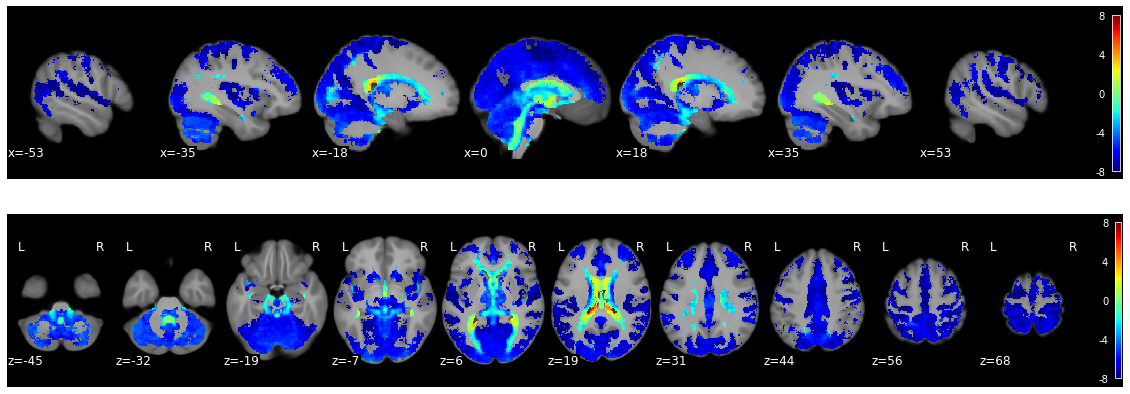

In [23]:
fig, axs = plt.subplots(2,1,figsize=(20,7))
fig8_panelAsag = plot_stat_map(lagmap_img,t1_bg,cmap='jet', vmax=8, display_mode='x', axes=axs[0], cut_coords=[-53,-35,-18,0,18,35,53])
fig8_panelAaxi = plot_stat_map(lagmap_img,t1_bg,cmap='jet', vmax=8, display_mode='z', axes=axs[1], cut_coords=[-45,-32,-19,-7,6,19,31,44,56,68])

In [24]:
fig8 = pn.Column(pn.pane.Matplotlib(fig),pn.pane.HoloViews(fig8_panelsBC))

In [27]:
fig8.save('./figures/Fig08_RapidTide_results.png')

Equivalent depiction for EO semgents.

![](./figures/Fig08_RapidTide_results.png)